In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from imblearn import over_sampling
from sklearn.decomposition import PCA
from sklearn.model_selection import RandomizedSearchCV
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, f1_score
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('BRS-2016-HMEQ.csv')
df

,bad,loan,mortdue,value,reason,job,yoj,derog,delinq,clage,ninq,clno,debtinc
0,1,1100,25860.0,39025.0,HomeImp,Other,10.5,0.0,0.0,94.36667,1.0,9.0,NaN
1,1,1300,70053.0,68400.0,HomeImp,Other,7.0,0.0,2.0,121.83330,0.0,14.0,NaN
2,1,1500,13500.0,16700.0,HomeImp,Other,4.0,0.0,0.0,149.46670,1.0,10.0,NaN
3,1,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,1700,97800.0,112000.0,HomeImp,Office,3.0,0.0,0.0,93.33334,0.0,14.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5955,0,88900,57264.0,90185.0,DebtCon,Other,16.0,0.0,0.0,221.80870,0.0,16.0,36.11235
5956,0,89000,54576.0,92937.0,DebtCon,Other,16.0,0.0,0.0,208.69210,0.0,15.0,35.85997
5957,0,89200,54045.0,92924.0,DebtCon,Other,15.0,0.0,0.0,212.27970,0.0,15.0,35.55659
5958,0,89800,50370.0,91861.0,DebtCon,Other,14.0,0.0,0.0,213.89270,0.0,16.0,34.34088


In [3]:
print("Num of missing values:")
print(df.isnull().sum().sum())

Num of missing values:
5271


In [4]:
# Unique values for all columns
unique_per_column = {col: df[col].unique() for col in df.columns}
print(unique_per_column)

{'bad': array([1, 0], dtype=int64), 'loan': array([ 1100,  1300,  1500,  1700,  1800,  2000,  2100,  2200,  2300,
        2400,  2500,  2800,  2900,  3000,  3100,  3200,  3300,  3400,
        3500,  3600,  3700,  3800,  3900,  4000,  4100,  4200,  4300,
        4400,  4500,  4700,  4800,  4900,  5000,  5100,  5200,  5300,
        5400,  5500,  5600,  5700,  5800,  5900,  6000,  6100,  6200,
        6300,  6400,  6500,  6600,  6700,  6800,  6900,  7000,  7100,
        7200,  7300,  7400,  7500,  7600,  7700,  7800,  7900,  8000,
        8100,  8200,  8300,  8400,  8500,  8600,  8700,  8800,  8900,
        9000,  9100,  9200,  9300,  9400,  9500,  9600,  9700,  9800,
        9900, 10000, 10100, 10200, 10300, 10400, 10500, 10600, 10700,
       10800, 10900, 11000, 11100, 11200, 11300, 11400, 11500, 11600,
       11700, 11800, 11900, 12000, 12100, 12200, 12300, 12400, 12500,
       12600, 12700, 12800, 12900, 13000, 13100, 13200, 13300, 13400,
       13500, 13600, 13700, 13800, 13900, 1400

Dataset characteristics are the following:

1) Total records = 5960 observations

2) Missing values = 5271

3) Binary indicator for loan default is 'bad' variable (bad = 1 for default, bad = 0 for non-default)

4) Numerical features (10 variables):

'loan' variable = loan amount requested;

'mortdue' variable = amount due on existing mortgage;
    
'value' variable = property value;
    
'yoj' variable = years on job;
    
'derog' variable = number of derogatory reports;
    
'delinq' variable = number of delinquent credit lines;
    
'clage' variable = age of oldest credit line;
    
'ninq' variable = number of recent credit inquiries;
    
'clno' variable = number of credit lines;
    
'debtinc' variable = debt-to-income ratio

5) Categorical features (2 variables):

'reason' variable = loan purpose (2 categories: DebtCon, HomeImp)

'job' variable = job category (6 categories: Mgr, Office, Other, ProfExe, Sales, Self)

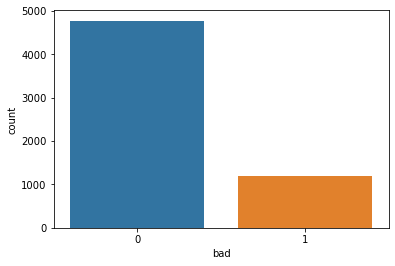

In [5]:
plt.figure(figsize = (6,4))
sns.countplot(x = "bad", data = df)
plt.show()

This dataset shows strong class imbalance, with defaults (bad = 1) representing a minority class. This imbalance required special handling through SMOTE oversampling.

In [6]:
corr = df.select_dtypes(include = np.number).corr() 
corr

,bad,loan,mortdue,value,yoj,derog,delinq,clage,ninq,clno,debtinc
bad,1.000000,-0.075099,-0.048219,-0.029954,-0.060238,0.276081,0.354107,-0.170499,0.174980,-0.004157,0.199835
loan,-0.075099,1.000000,0.228595,0.335393,0.105728,-0.001302,-0.035144,0.088540,0.044487,0.072631,0.084735
mortdue,-0.048219,0.228595,1.000000,0.875666,-0.088480,-0.049516,-0.001044,0.140047,0.031392,0.323631,0.154939
value,-0.029954,0.335393,0.875666,1.000000,0.007759,-0.048689,-0.014103,0.171238,-0.004398,0.269149,0.132174
yoj,-0.060238,0.105728,-0.088480,0.007759,1.000000,-0.065879,0.038153,0.201718,-0.071627,0.024838,-0.055891
derog,0.276081,-0.001302,-0.049516,-0.048689,-0.065879,1.000000,0.211832,-0.083047,0.173934,0.061884,0.017065
delinq,0.354107,-0.035144,-0.001044,-0.014103,0.038153,0.211832,1.000000,0.022488,0.067812,0.164639,0.052364
clage,-0.170499,0.088540,0.140047,0.171238,0.201718,-0.083047,0.022488,1.000000,-0.116935,0.237987,-0.046477
ninq,0.174980,0.044487,0.031392,-0.004398,-0.071627,0.173934,0.067812,-0.116935,1.000000,0.088389,0.141344
clno,-0.004157,0.072631,0.323631,0.269149,0.024838,0.061884,0.164639,0.237987,0.088389,1.000000,0.185539


<AxesSubplot:>

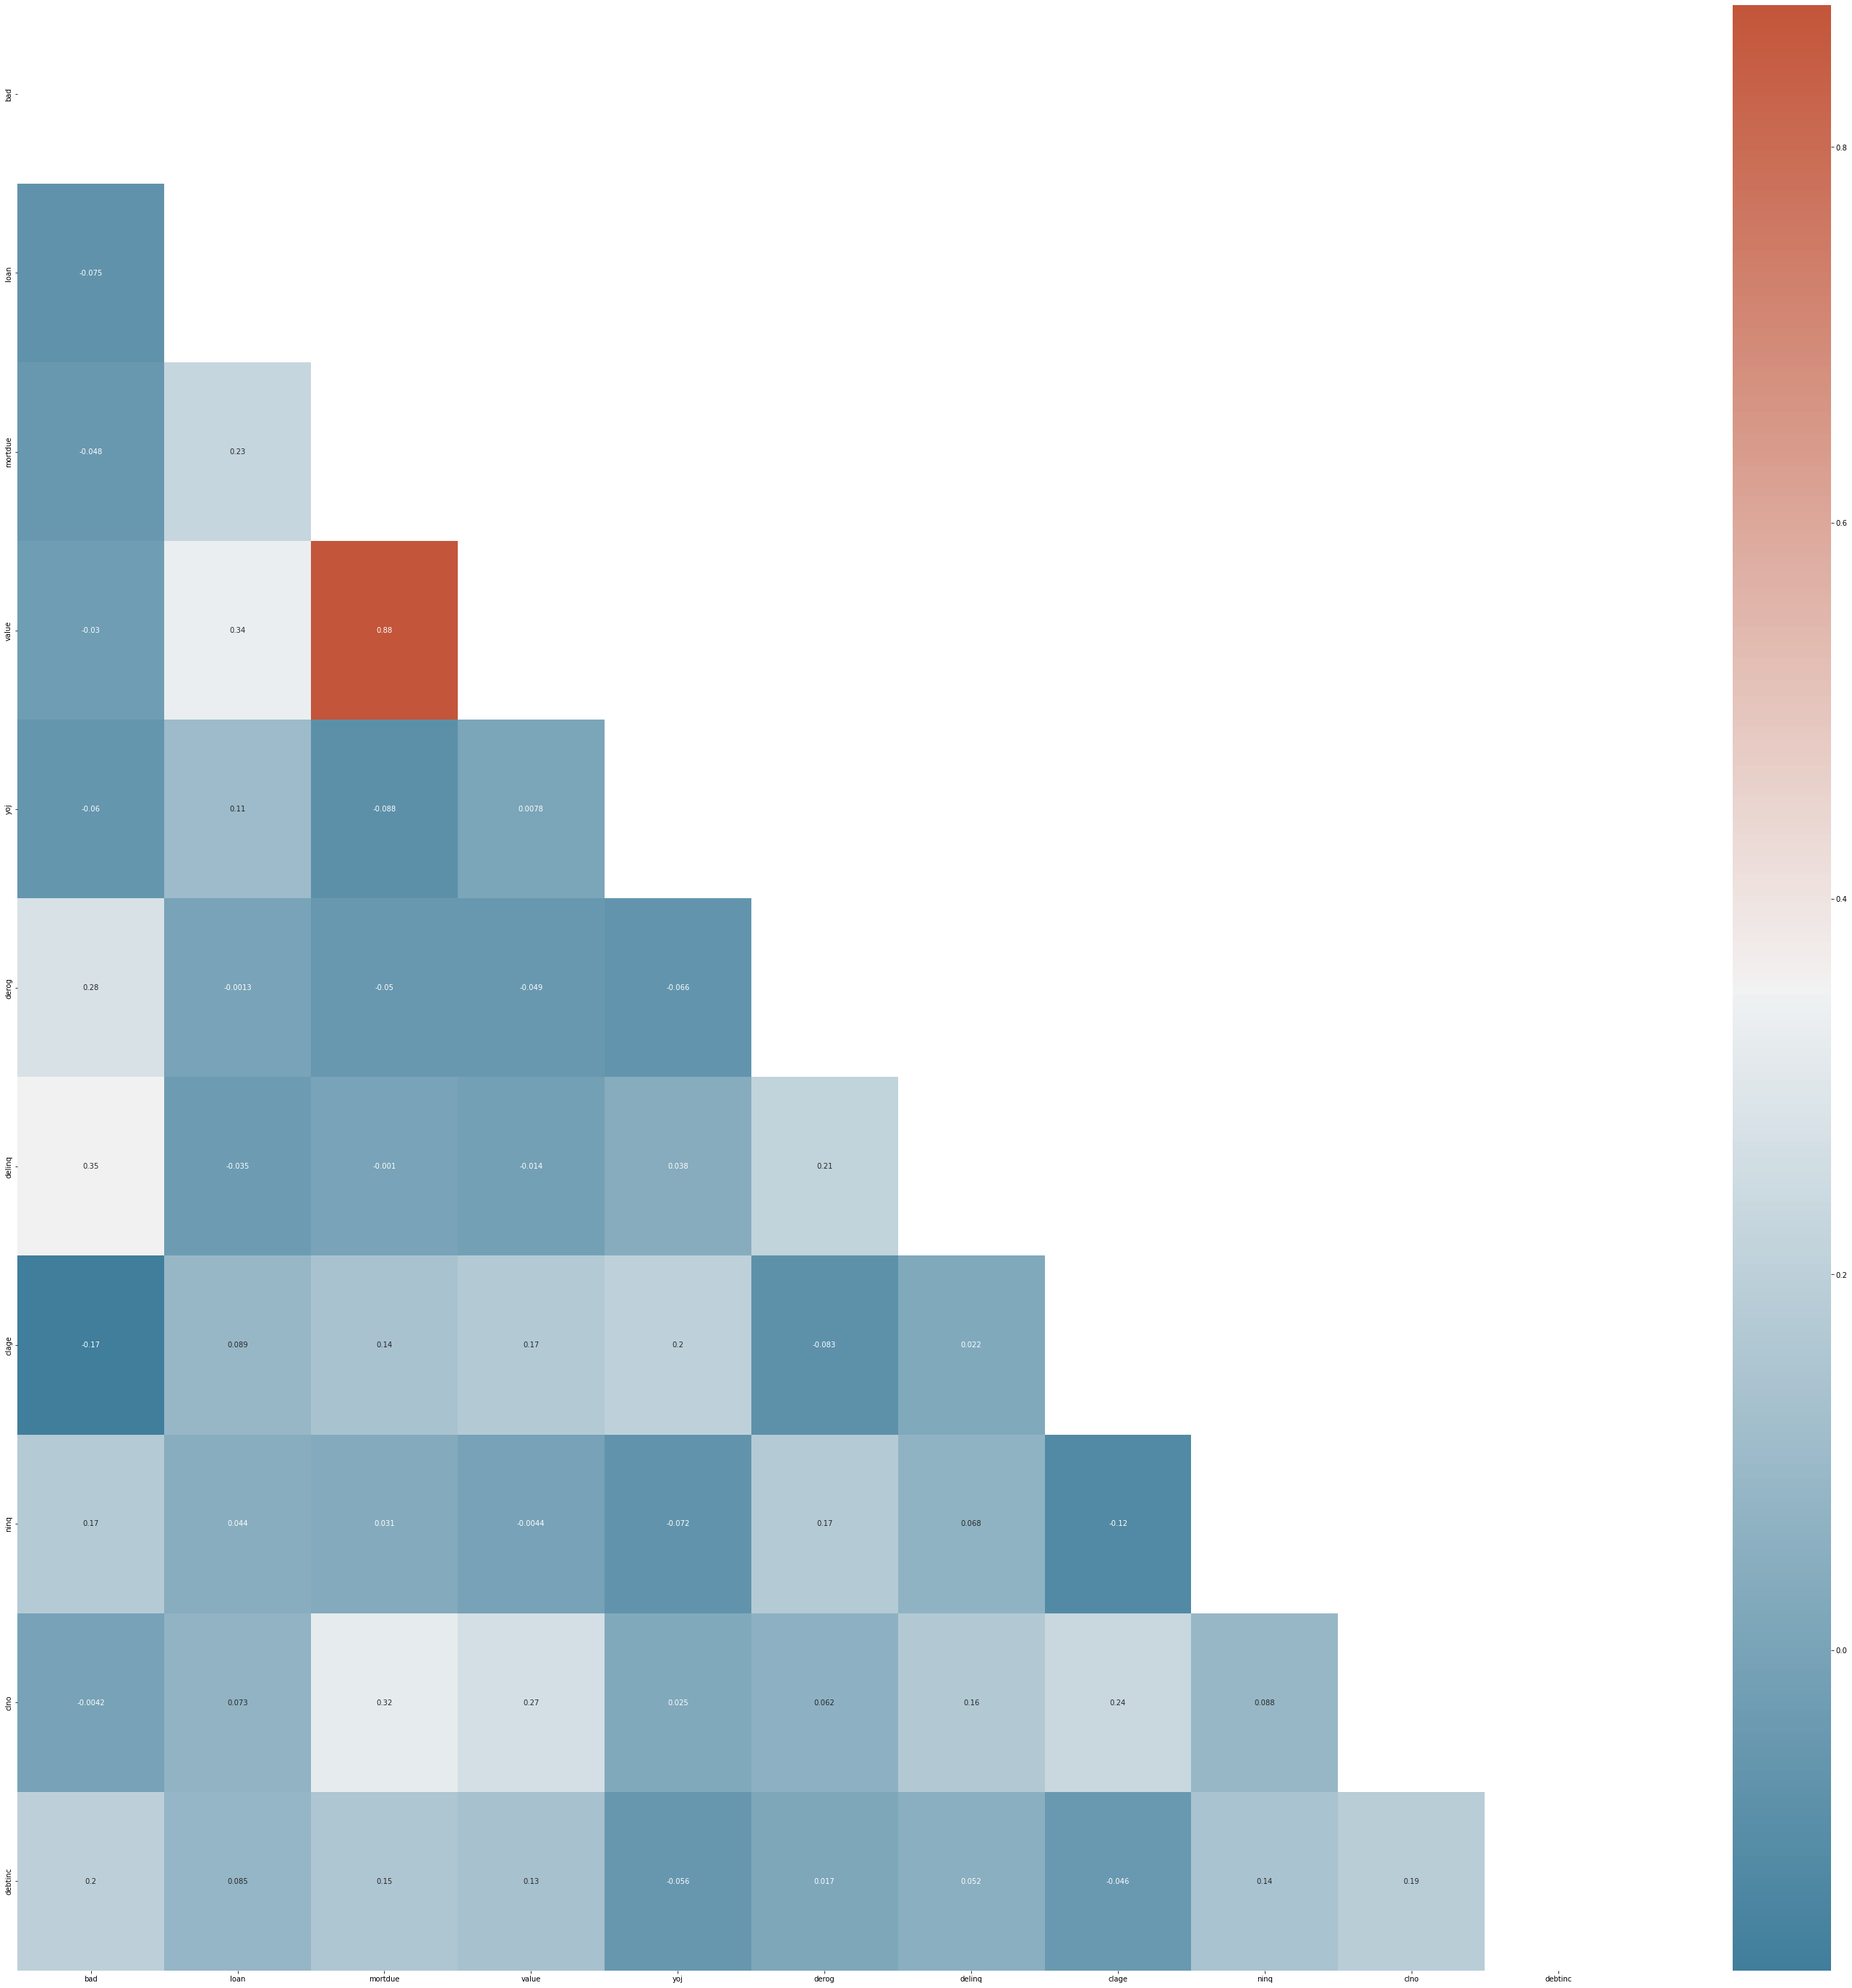

In [7]:
mask = np.triu(np.ones_like(corr, dtype = bool)) 

f, ax = plt.subplots(figsize = (50, 50))   
cmap = sns.diverging_palette(230, 20, as_cmap = True) 
sns.heatmap(corr, mask = mask, cmap = cmap, annot = True) 

Based on the correlation matrix: 

Strongest predictors of default are 1) delinquent credit lines (delinq) with r = 0.354, 2) derogatory reports (derog) with r = 0.276, 3) debt-to-income ratio (debtinc) with r = 0.2, 4) recent credit inquiries (ninq) with r = 0.175

Protective factors are 1) age of oldest credit line (clage) with r = -0.170 (established credit history reduces default risk), 2) loan amount with r = -0.075 (larger loans show lower default rates)

In [8]:
# Now we can filter out all values whose correlation is clearly equal to 1 (without rounding), 
# i.e. a completely duplicate column in terms of correlation.
upper_triangle = corr.abs().where(np.triu(mask, k = 1).astype(bool)) 
to_drop = [column for column in upper_triangle.columns if any(upper_triangle[column] == 1)] 
to_drop

[]

In [9]:
# Define features and target
target = 'bad'
features = [col for col in df.columns if col != target]

# Split data into X and y
X = df[features]
y = df[target]

In [10]:
numeric_features = X.select_dtypes(include = ['int64', 'float64']).columns 
numeric_features

Index(['loan', 'mortdue', 'value', 'yoj', 'derog', 'delinq', 'clage', 'ninq',
       'clno', 'debtinc'],
      dtype='object')

In [11]:
categorical_features = X.select_dtypes(include = ['object', 'category']).columns 
categorical_features

Index(['reason', 'job'], dtype='object')

In [12]:
X[categorical_features].nunique()

reason    2
job       6
dtype: int64

In [13]:
# Preprocessing pipelines
preprocessor = ColumnTransformer([
    ('num', Pipeline([
        ('imputer', SimpleImputer(strategy = 'median')),
        ('scaler', StandardScaler())
    ]), numeric_features),
    ('cat', Pipeline([
        ('imputer', SimpleImputer(strategy = 'most_frequent')),
        ('encoder', OneHotEncoder(handle_unknown = 'ignore'))
    ]), categorical_features)
])

In [14]:
# Split data

# Let's move on to splitting the dataset into X_train and X_test, y_train and y_test. Let's use train_test_split.
# test_size = 0.2 -> set what size the test dataset should be;
# set random_state for reproducibility of the experiment;
# set stratify variable -> allows us to model this partitioning process with an equal share of each class 
# (we have already seen that we have 2 classes, and there is a clear imbalance between them).
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = y)

# Then we need to do some preprocessing:
# preprocessed_X_train -> what will be the result of using pipeline preprocessor;
# preprocessor.fit_transform() -> use fit_transform() to train it and then return us the corresponding transformed X_train
preprocessed_X_train = preprocessor.fit_transform(X_train)

# We do the same operation for X_test, but using just transform, because our preprocessor is already “familiarized” with 
# X_train data and now we just need to transform our test dataset.
preprocessed_X_test = preprocessor.transform(X_test)

In [15]:
# Preprocessing results in a ‘numpy’-dataset consisting of all numeric values, 
# which can now be passed to the input of our machine learning model.
preprocessed_X_train

array([[-0.96457364, -0.0582124 , -0.34622182, ...,  0.        ,
         1.        ,  0.        ],
       [ 0.21978268, -0.57136831, -0.52632263, ...,  0.        ,
         0.        ,  0.        ],
       [-0.62618612, -0.23106815, -0.35973647, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.24327393, -0.18650138, -1.0143023 , ...,  0.        ,
         0.        ,  0.        ],
       [-0.75976014,  1.75619403,  1.30879975, ...,  0.        ,
         0.        ,  0.        ],
       [-1.5166796 , -1.40398244, -1.50040444, ...,  0.        ,
         0.        ,  0.        ]])

In [16]:
y_train

609     0
4015    1
1591    0
1127    0
920     0
       ..
3287    1
4301    1
2821    0
1167    0
2       1
Name: bad, Length: 4768, dtype: int64

In [17]:
feature_names = preprocessor.get_feature_names_out()

feature_names

array(['num__loan', 'num__mortdue', 'num__value', 'num__yoj',
       'num__derog', 'num__delinq', 'num__clage', 'num__ninq',
       'num__clno', 'num__debtinc', 'cat__reason_DebtCon',
       'cat__reason_HomeImp', 'cat__job_Mgr', 'cat__job_Office',
       'cat__job_Other', 'cat__job_ProfExe', 'cat__job_Sales',
       'cat__job_Self'], dtype=object)

In [18]:
# We can look at the number of feature_names. 
# There are 18 feature names. Now we have an 18-dimensional vector on which we will make a prediction.
len(feature_names)

18

In [19]:
# We have an imbalance in the data. 
# To get rid of the imbalance, we can use different strategies - either oversampling, undersampling, or generating synthetic data.

# SMOTE is some methodology that allows us to do synthetic data generation.
# Set a random state so that the experiment is reproducible.
smote = over_sampling.SMOTE(random_state = 42)

# SMOTE results in some X and y [which are synthetically generated].

# We do fit_resample() -> both train and resample (we resample our X_train, and we don't use X_test, 
# because this is some real data, on which we would like to check the quality of ml models, 
# therefore we won't sample them; we will sample X_train - what we have in reality and to which we have access).
X_res, y_res = smote.fit_resample(preprocessed_X_train, y_train)

In [20]:
X_res

array([[-0.96457364, -0.0582124 , -0.34622182, ...,  0.        ,
         1.        ,  0.        ],
       [ 0.21978268, -0.57136831, -0.52632263, ...,  0.        ,
         0.        ,  0.        ],
       [-0.62618612, -0.23106815, -0.35973647, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 2.008536  ,  1.8912756 ,  2.03061804, ...,  0.        ,
         0.        ,  0.        ],
       [-0.82465919,  1.76777409,  1.01231243, ...,  0.        ,
         0.        ,  0.03344156],
       [-0.88286781, -1.63257795, -1.45958506, ...,  0.        ,
         0.        ,  0.        ]])

In [21]:
# Let's visualize how SMOTE works.
# Use the principal component analysis (PCA) method and select the first 2 principal components, 
# i.e. 2 certain axes in this 18-dimensional space, projection on which will give the most information, 
# i.e. on which we will be able to see all the important information we need, and we move from 18-dimensional space 
# to 2-dimensional space.
pca = PCA(n_components = 2)
 
X_pca = pca.fit_transform(preprocessed_X_train)

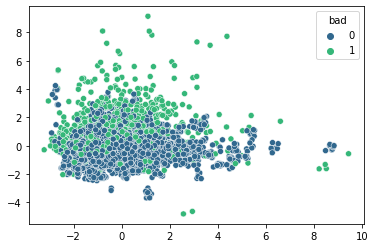

In [22]:
sns.scatterplot(x = X_pca[:,0], y = X_pca[:,1], hue = y_train, palette = 'viridis')

plt.show()

# reminder: here we did the visualization on NOT yet processed data (i.e. NOT generated with SMOTE).

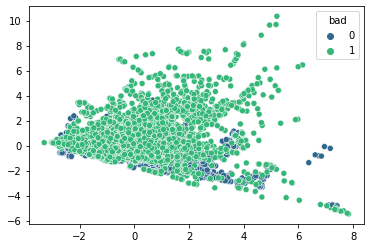

In [23]:
# Now let's see what happens after the synthetic data generator is applied
pca = PCA(n_components = 2)
X_pca = pca.fit_transform(X_res) 
sns.scatterplot(x = X_pca[:,0], y = X_pca[:,1], hue = y_res, palette = 'viridis') 

plt.show()

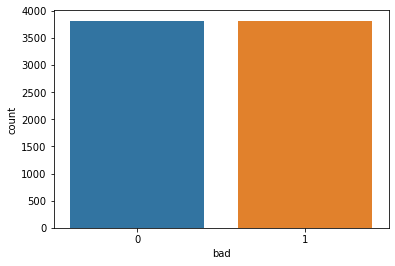

In [24]:
plt.figure(figsize=(6,4))
sns.countplot(x = y_res) 
plt.show()

# The number of representatives of each class is the same

In [25]:
lr_model = LogisticRegression(max_iter = 1000)

# We will not just train our model directly, but use a strategy to find optimal hyperparameters
lr_params = {
    'C': np.logspace(-4, 2, 7) 
} 

In [26]:
lr_search = RandomizedSearchCV(
    lr_model, lr_params, n_iter = 5, scoring = "f1", cv = 4, n_jobs = -1, random_state = 42
) 

lr_search.fit(X_res, y_res)

RandomizedSearchCV(cv=4, estimator=LogisticRegression(max_iter=1000), n_iter=5,
                   n_jobs=-1,
                   param_distributions={'C': array([1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02])},
                   random_state=42, scoring='f1')

In [27]:
def evaluate_model(model): 
    y_pred = model.predict(preprocessed_X_test)  
    print(classification_report(y_test, y_pred))

In [28]:
evaluate_model(lr_search.best_estimator_)

              precision    recall  f1-score   support

           0       0.89      0.79      0.83       954
           1       0.42      0.61      0.49       238

    accuracy                           0.75      1192
   macro avg       0.65      0.70      0.66      1192
weighted avg       0.79      0.75      0.77      1192



Model performance analysis

Overall performance: accuracy = 75%, weighted F1-Score = 0.77, macro F1-Score = 0.66.

Class-Specific performance:

For non-default class (class 0): precision = 89% (high confidence when predicting non-default), recall = 79% (correctly identifies 79% of actual non-defaults), F1-Score = 83% (strong overall performance), support = 954 observations.

For default class (class 1): precision = 42% (only 42% of predicted defaults are actual defaults), recall = 61% (captures 61% of actual defaults), F1-Score = 49% (moderate performance), support = 238 observations.

So, we see poor precision for defaults (42% precision means high false positive rate), also despite SMOTE, default class performance remains suboptimal.

The model is conservative in default prediction, potentially leading to rejected good customers (false positives): 58% of predicted defaults are actually good customers), and missed defaults (false negatives): 39% of actual defaults go undetected.

In [29]:
lr_search.best_params_

{'C': 10.0}

In [30]:
model = lr_search.best_estimator_

In [31]:
model.predict(preprocessed_X_test)

array([0, 0, 0, ..., 1, 0, 0], dtype=int64)

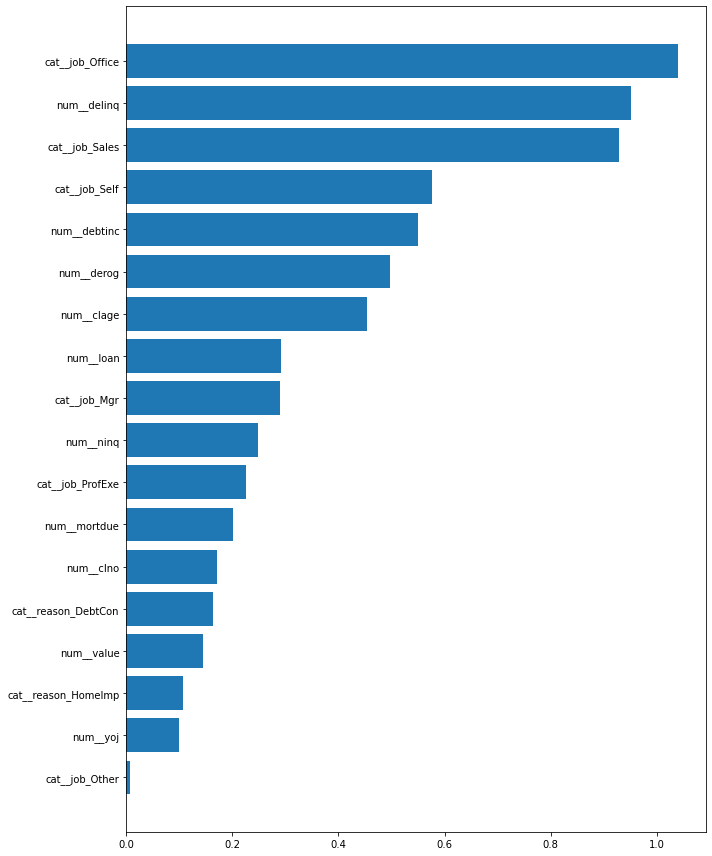

In [32]:
coefs = np.abs(model.coef_[0])

sorted_indices = np.argsort(coefs)

plt.figure(figsize=(10, 12))
plt.barh(range(len(sorted_indices)), coefs[sorted_indices])
plt.yticks(range(len(sorted_indices)), [feature_names[i] for i in sorted_indices])
plt.tight_layout()
plt.show()

We have cat_job_Office - some attribute that is most important in deciding whether to do credit scoring or not ('cat' means that the attribute is categorical)